# 2D Softmax Position-Velocity Model

Note the *2D* part refers to the ball is being shot from a point to different points in the goal, **not** that the input features are 2D. In fact, the input features are 4D `[x, y, dx, dy]` vectors

### Load Data

In [13]:
%store -r shots

df = shots['df']
sideways = df.T

X, Y = np.array(sideways.ix[['x0', 'y0', 'dx0', 'dy0']]).astype(float), np.array(sideways.ix['label']).astype(int)

### Data

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  app.launch_new_instance()
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


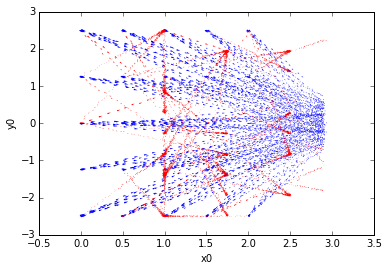

In [14]:
colormap = np.array(['r', 'b'])
labels = df['label']
axes = df.plot(kind='scatter', x='x0', y='y0', c=colormap[labels], s=0)
axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

### Train

In [15]:
from softmax import Softmax

sm = Softmax(X, Y, C=2, learning_rate=.1, regularizer=.001, gradient_checking=False, inspect=True)

def states(iters):
    for _ in range(iters):
        sm.learn()
        yield sm.info
        
states = list(states(2500))

### Plot Losses

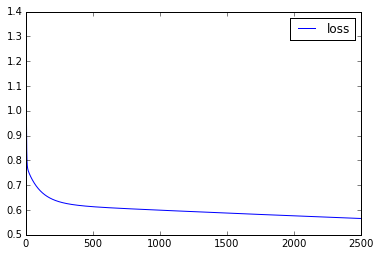

In [16]:
def loss_averages():
    for state in states:
        yield state.loss
        
loss_avgs = list(loss_averages())

pd.DataFrame(loss_avgs, columns=['loss']).plot()

### Visualize

Notice the plots are linear because of the following recurrence relation:

$$v_t = x_{t+1} - x_t$$

This formula follows by definition of $x_t$:

$$x_t = x_{t-1} + v_{t-1}$$

Intuitively, as the difference between $x$ points gets smaller, the difference between $y$ points get smaller **by the same amount**

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:18: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:19: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:28: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


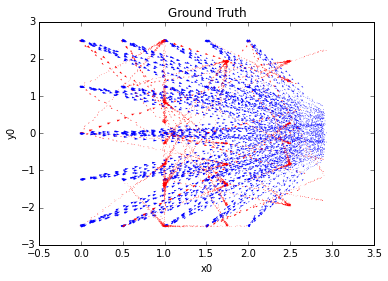

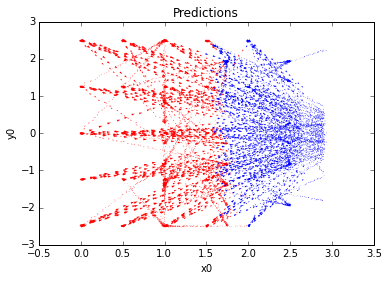

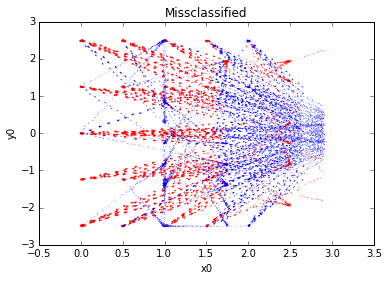

In [17]:
from ipywidgets import interact, fixed

@interact(X=fixed(X), Y=fixed(Y), view_index=(0, len(states)-1), states=fixed(states))
def plot(X, Y, view_index, states):
    """View decision boundary over time
    
    We have the state of the model (i.e. its parameters) after every time step.
    We want to see how the model learns over time. Hence create a one-off instance
    of a softmax with its old parameters and ask it to make a bunch of predictions!
    """
    s = states[view_index]
    sm = Softmax(X=X, ys_train=Y, C=2, W=s.W, b=s.b)
    
    # Plotting
    colormap = np.array(['r', 'b'])

    # Plot the gold standard in a plot right next to it
    axes = df.plot(kind='scatter', x='x0', y='y0', c=colormap[df['label']], title='Ground Truth', s=0)
    axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[df['label']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Predictions
    df['predictions'] = sm.predict(X)
    axes = df.plot(kind='scatter', x='x0', y='y0', c=colormap[df['predictions']], title='Predictions', s=0)
    axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Misclassified examples
    df['correct'] = df['label'] == df['predictions']
    axes = df.plot(kind='scatter', x='x0', y='y0', c=colormap[df['correct']], title='Missclassified', s=0)
    axes.quiver(df['x0'], df['y0'], df['dx0'], df['dy0'], color=colormap[df['correct']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

In [18]:
df['correct'].sum() / len(df)

0.70200956937799042